In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit_cst_pro as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 0.01, 900]


times = np.linspace(50, 90, 41)

df = pd.read_csv('2017-03-16_PRO_multi_well_inference_input_multi_well_t_50.csv', header=None)
org_values = np.transpose(df.to_numpy())
org_values = org_values[:41,:]


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((41,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 4
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 3
New dimension: 7


Create uniform log prior

In [5]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 0.00001
prior_arr_upper[1] = 0.1
prior_arr_lower[2] = 1
prior_arr_upper[2] = 4000
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_9210/3449605926.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.4
1     534     0:01.6
2     1029    0:02.7
3     1521    0:03.8
20    8637    0:17.0
40    15033   0:28.3
60    20946   0:39.0
80    27150   0:50.4
100   33396   1:01.9
120   39291   1:12.3
140   45024   1:22.4
160   51042   1:32.9
180   56871   1:43.3
200   62655   1:54.0
220   68361   2:04.3
240   74223   2:14.7
260   80244   2:25.4
280   86151   2:35.9
300   91800   2:46.2
320   97725   2:56.9
340   103680   3:07.4
360   109365   3:17.8
380   115170   3:28.2
400   121113   3:38.8
420   126882   3:49.5
440   132774   4:00.1
460   138762   4:10.9
480   144342   4:20.9
500   149913   4:31.0
520   155958   4:42.0
540   161907   4:52.9
560   167697   5:03.3
580   173436   5:13.6
600   178923   5:23.6
620   184665   5:33.9
640   190599   5:44.7
660   196302   5:54.6
680   201969   6:04.7
700   207960   6:15.5
720   213792   6:25.9
740   219864   6:38.6
760   225903   6

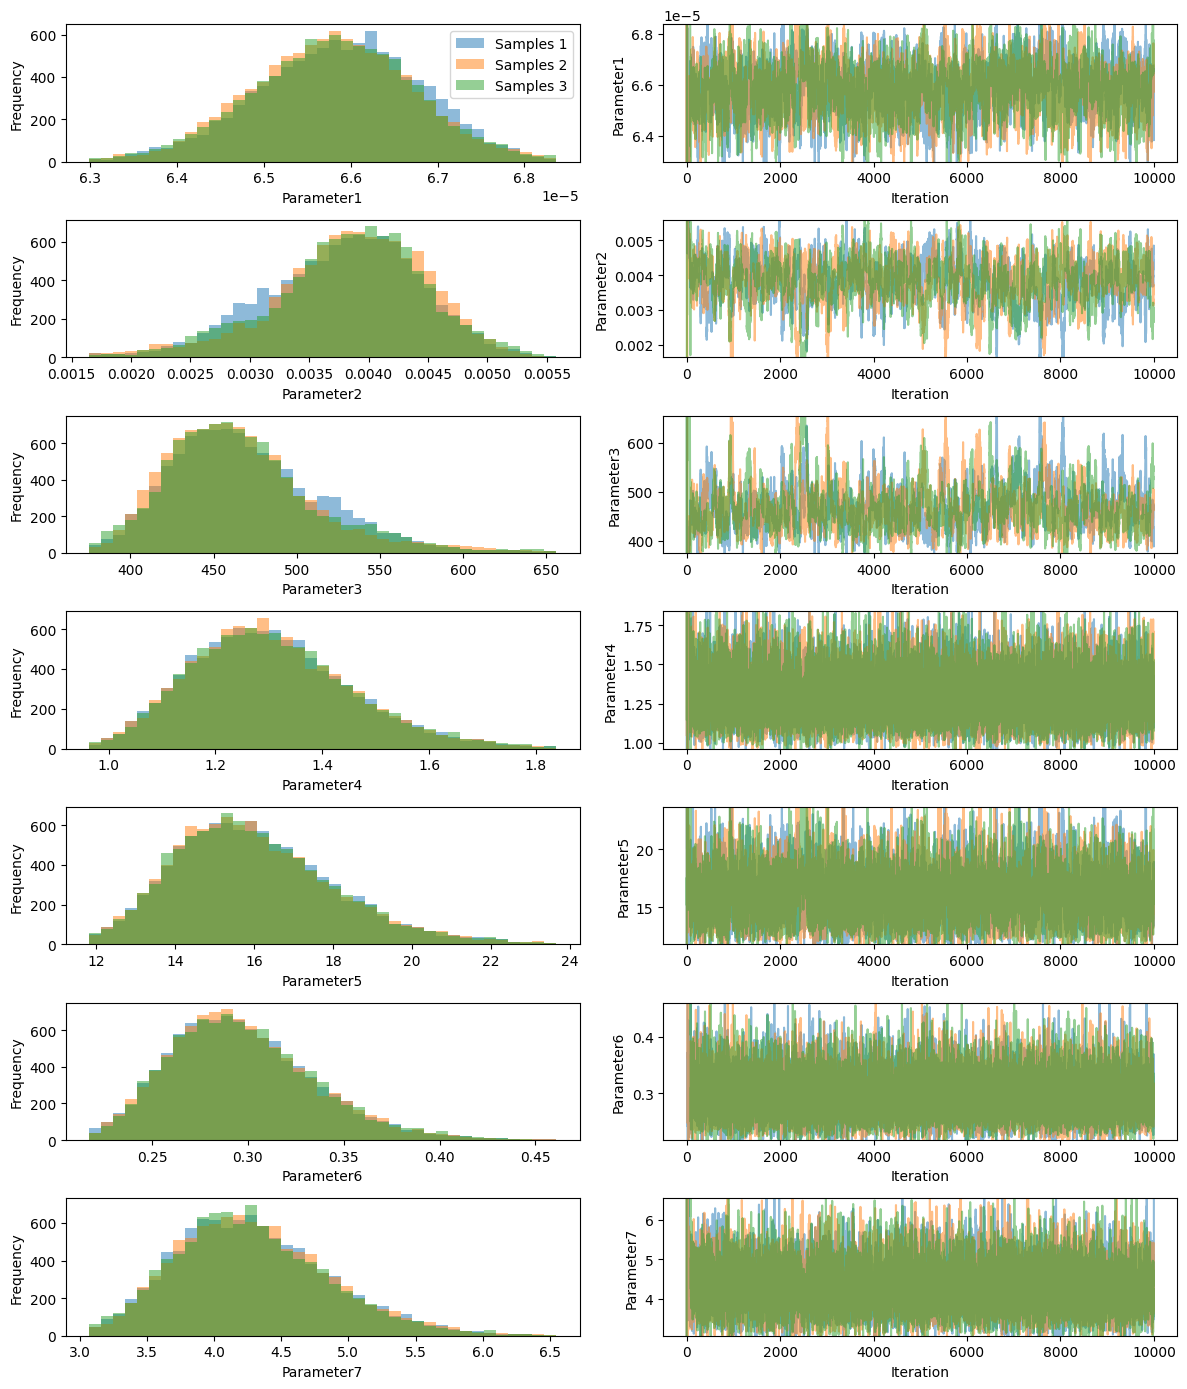

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [8]:
print(log_likelihood([6.57041322e-05, 3.97538870e-03, 4.54055922e+02, 1.27144782e+00,
 1.49186342e+01, 2.85616624e-01, 4.13946887e+00]))

AIC = 2*7 - 2*log_likelihood([6.57041322e-05, 3.97538870e-03, 4.54055922e+02, 1.27144782e+00,
 1.49186342e+01, 2.85616624e-01, 4.13946887e+00])

print(AIC)

-360.225348056953
734.450696113906


In [9]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(9900, 7)
[6.49146075e-05 4.28689093e-03 4.38800362e+02 1.34602747e+00
 1.51656651e+01 3.04310766e-01 4.67171839e+00]
[[6.49146075e-05 4.28689093e-03 4.38800362e+02 ... 1.51656651e+01
  3.04310766e-01 4.67171839e+00]
 [6.48748821e-05 4.19462640e-03 4.36874747e+02 ... 1.52941825e+01
  2.92228529e-01 4.33114404e+00]
 [6.48683919e-05 4.12668386e-03 4.45470637e+02 ... 1.42198459e+01
  2.95178296e-01 4.55482418e+00]
 ...
 [6.40525970e-05 4.71150085e-03 3.88400960e+02 ... 1.59906551e+01
  2.65727815e-01 3.78091319e+00]
 [6.38185716e-05 4.84349967e-03 4.20116279e+02 ... 1.59976625e+01
  3.11093105e-01 6.18873138e+00]
 [6.57723596e-05 4.62671360e-03 4.27485187e+02 ... 1.89042791e+01
  2.42949353e-01 6.58411159e+00]]


In [10]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


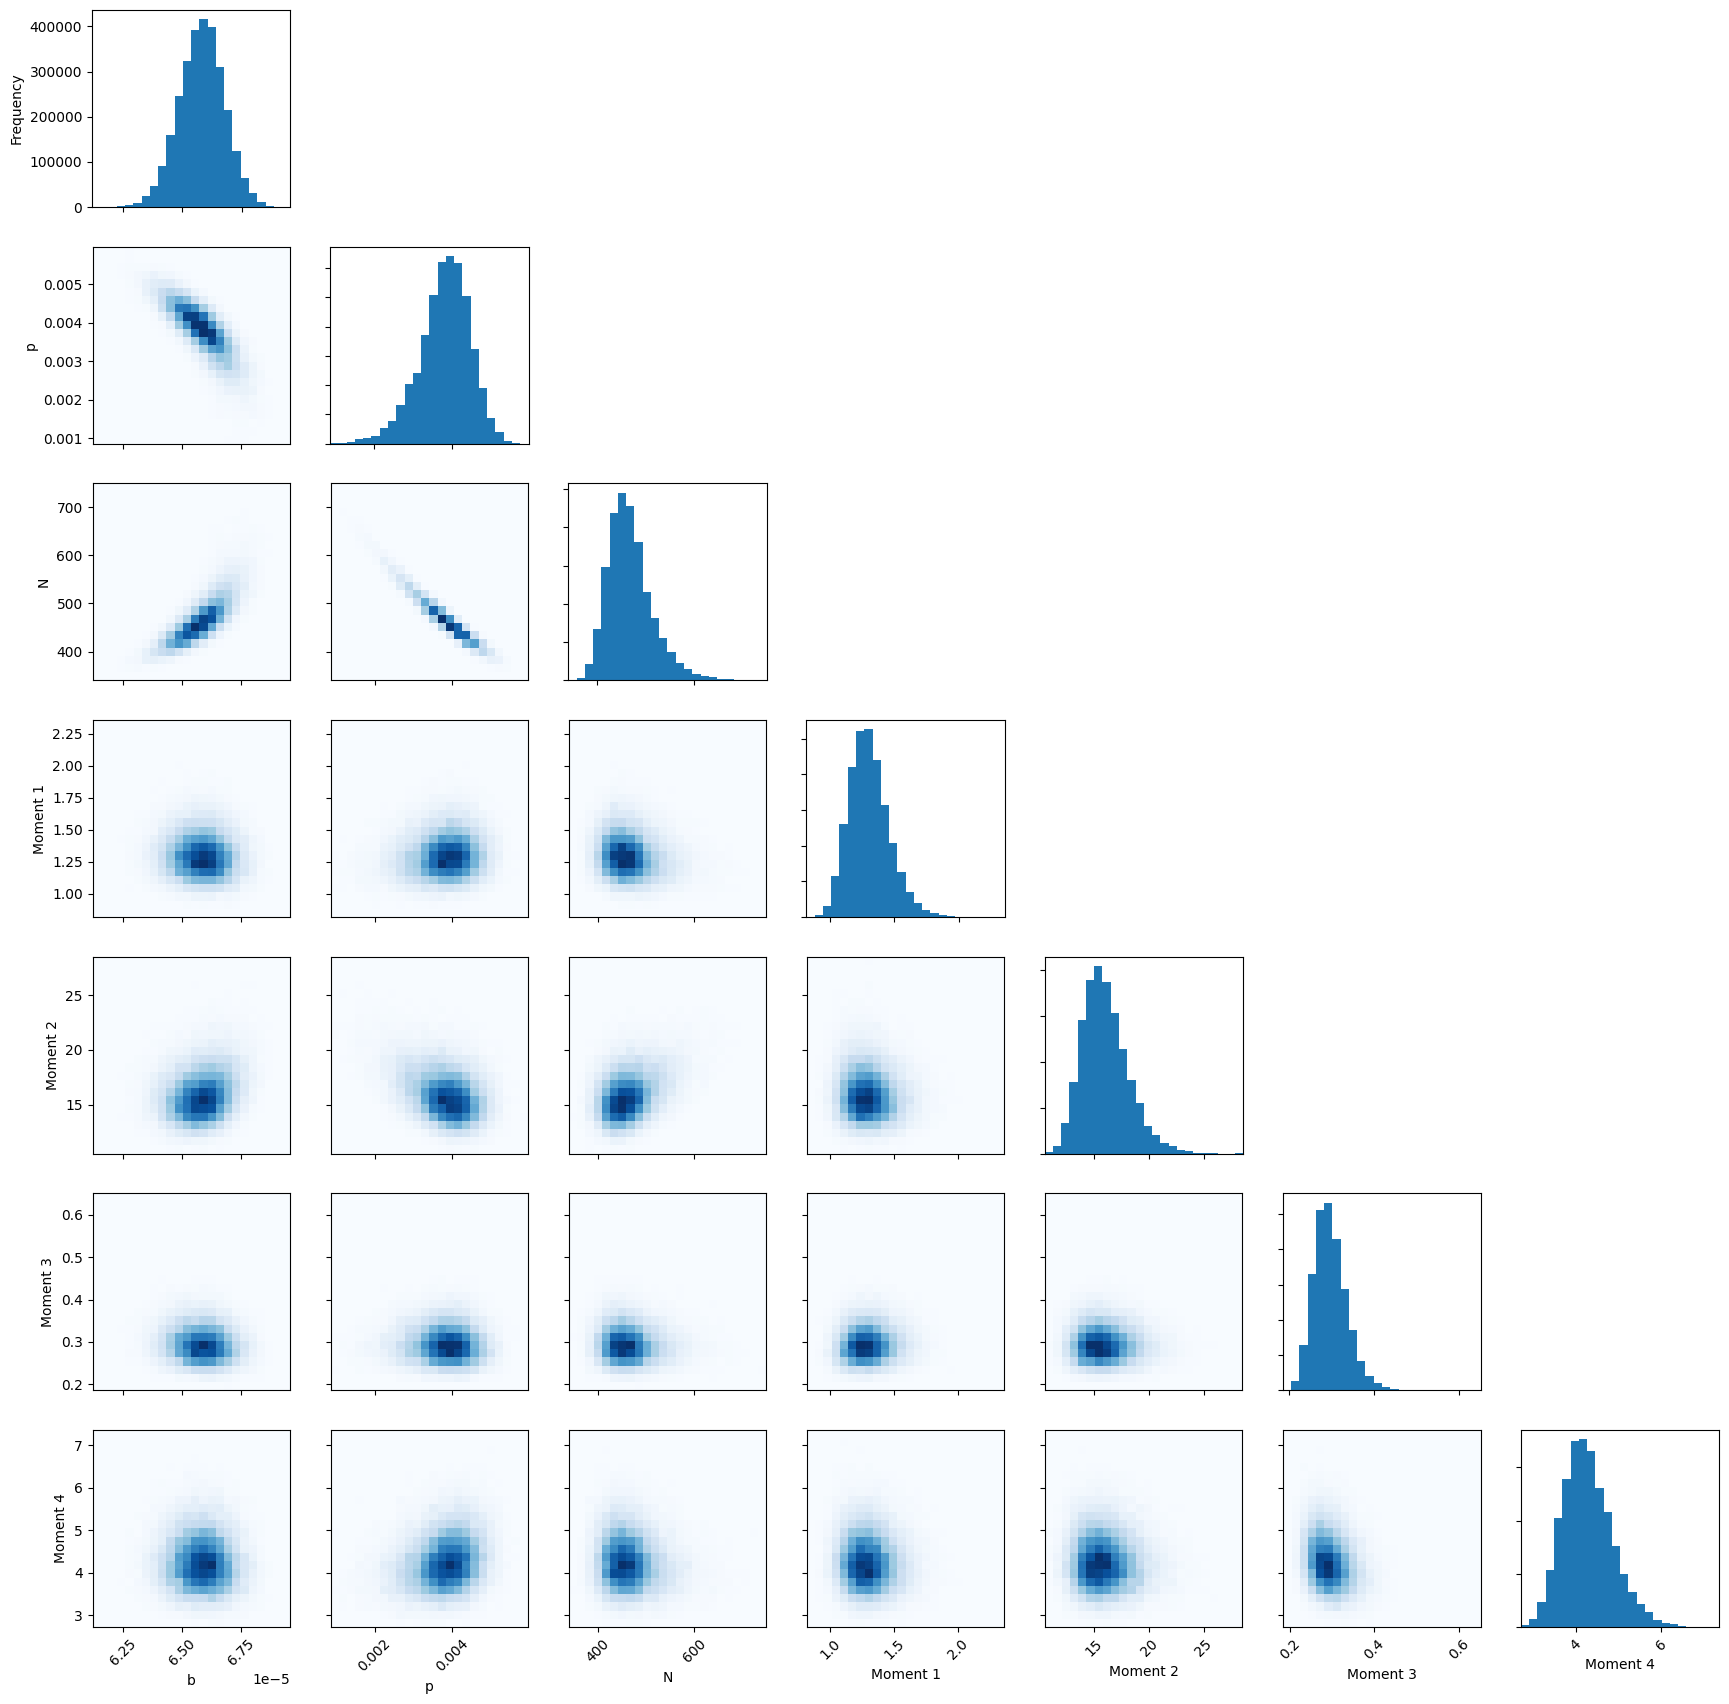

In [11]:


parameter_names = ["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.show()

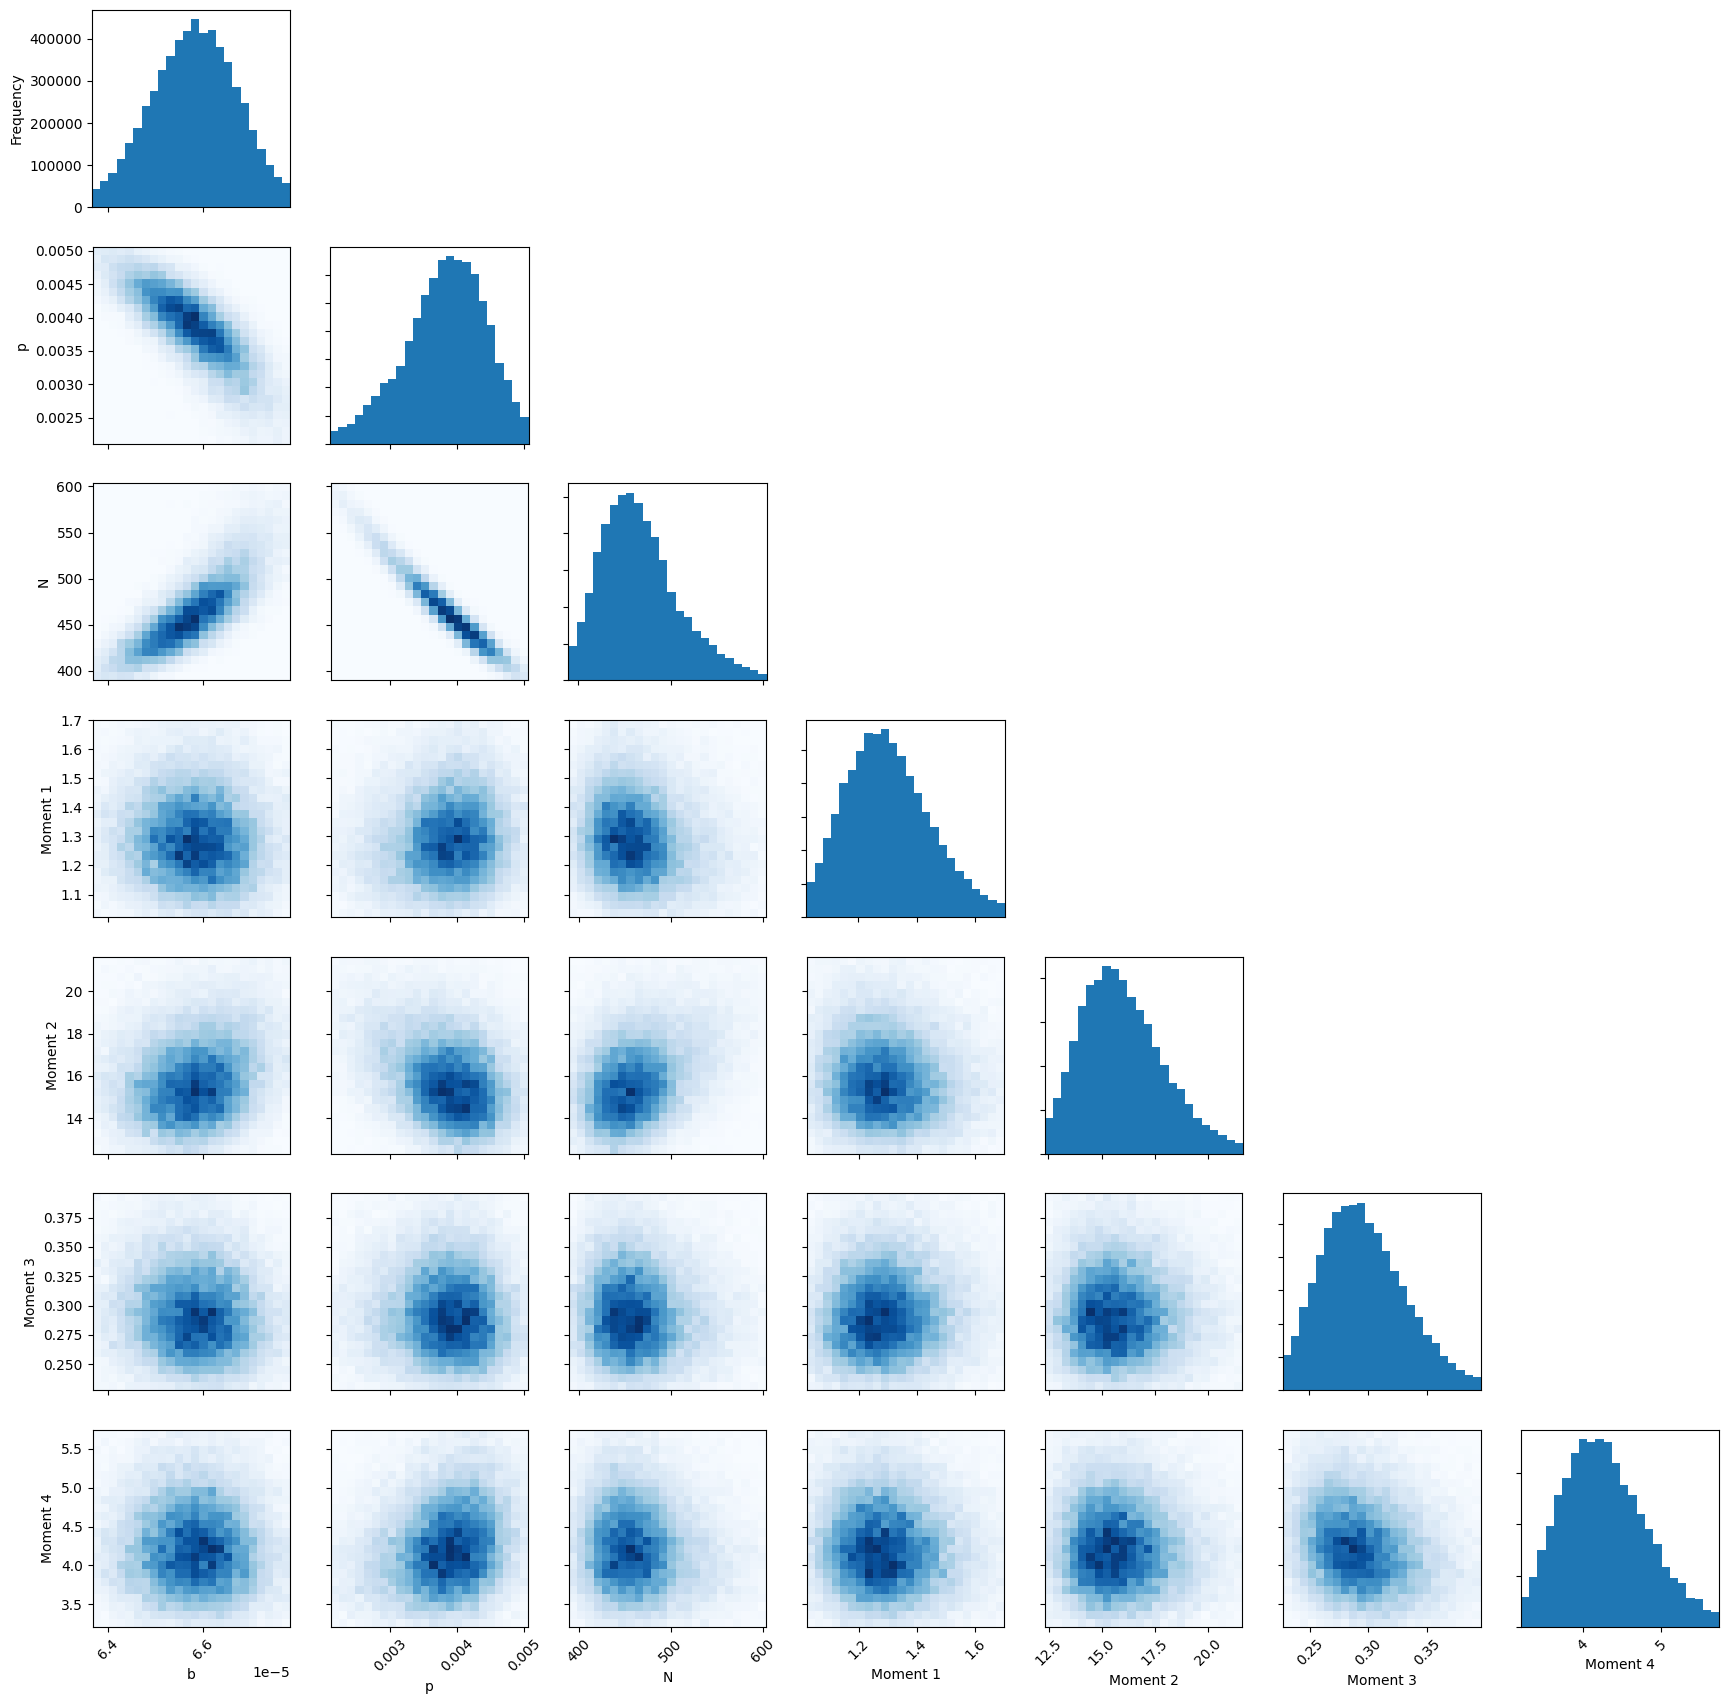

In [12]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

In [13]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess      ess per sec.
--------  ------  ------  ------  ------  ------  ------  -------  ------  -------  --------------
b         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.02    254.65   0.04
p         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.03    189.64   0.03
N         471.50  47.73   394.92  437.79  465.14  497.53  581.68   1.03    185.84   0.03
Moment 1  1.30    0.16    1.04    1.19    1.29    1.40    1.65     1.00    4062.49  0.69
Moment 2  16.08   2.10    12.62   14.57   15.84   17.34   20.83    1.00    1039.28  0.18
Moment 3  0.30    0.04    0.23    0.27    0.29    0.32    0.38     1.00    4010.31  0.68
Moment 4  4.29    0.58    3.31    3.87    4.23    4.65    5.58     1.00    3341.99  0.57


In [14]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [15]:

parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess       ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  --------  --------------
b         6.59e-05  9.56e-07  6.39e-05  6.52e-05  6.59e-05  6.65e-05  6.77e-05  1.02    255       0.0432
p         0.00377   0.000669  0.00233   0.00335   0.00382   0.00423   0.00495   1.03    190       0.0322
N         471       47.7      395       438       465       498       582       1.03    186       0.0315
Moment 1  1.3       0.155     1.04      1.19      1.29      1.4       1.65      1       4.06e+03  0.689
Moment 2  16.1      2.1       12.6      14.6      15.8      17.3      20.8      1       1.04e+03  0.176
Moment 3  0.296     0.0384    0.233     0.269     0.293     0.319     0.382     1       4.01e+03  0.68
Moment 4  4.29      0.584     3.31      3.87      4.23      4.65      5.58      1       3.34e+03  0.567


In [16]:
import math
print(math.log(4))
results.mean()

print(len(results.mean()))

AIC = 2*len(results.mean()) - 2*log_likelihood(results.mean())

print(AIC)


BIC = len(results.mean())*math.log(4) - 2*log_likelihood(results.mean())

print(BIC)

1.3862943611198906
7
735.3945970969442
731.0986576247834


In [17]:
shape_chains = np.shape(AllChains)

DIC_1 = 0
for i in range(shape_chains[0]):
    thetas = AllChains[i,:]
    DIC_1 += -2*log_likelihood(thetas)

DIC_1 = DIC_1/shape_chains[0]

DIC_2 = -2*log_likelihood(results.mean())

DIC = 2*DIC_1 - DIC_2

print(DIC)



734.5786688979149


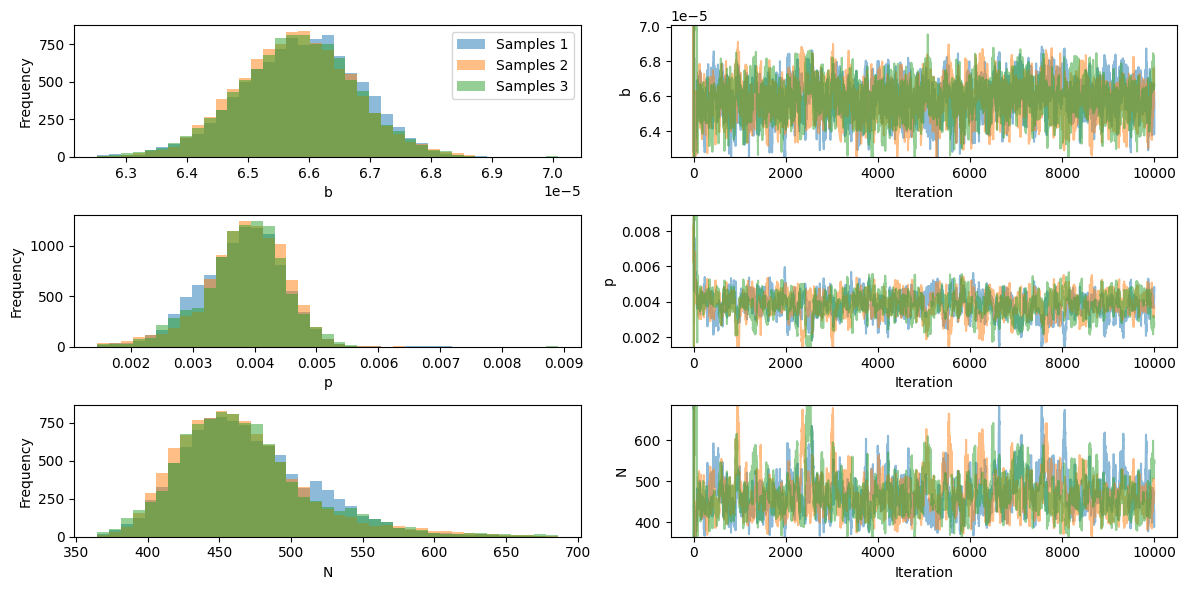

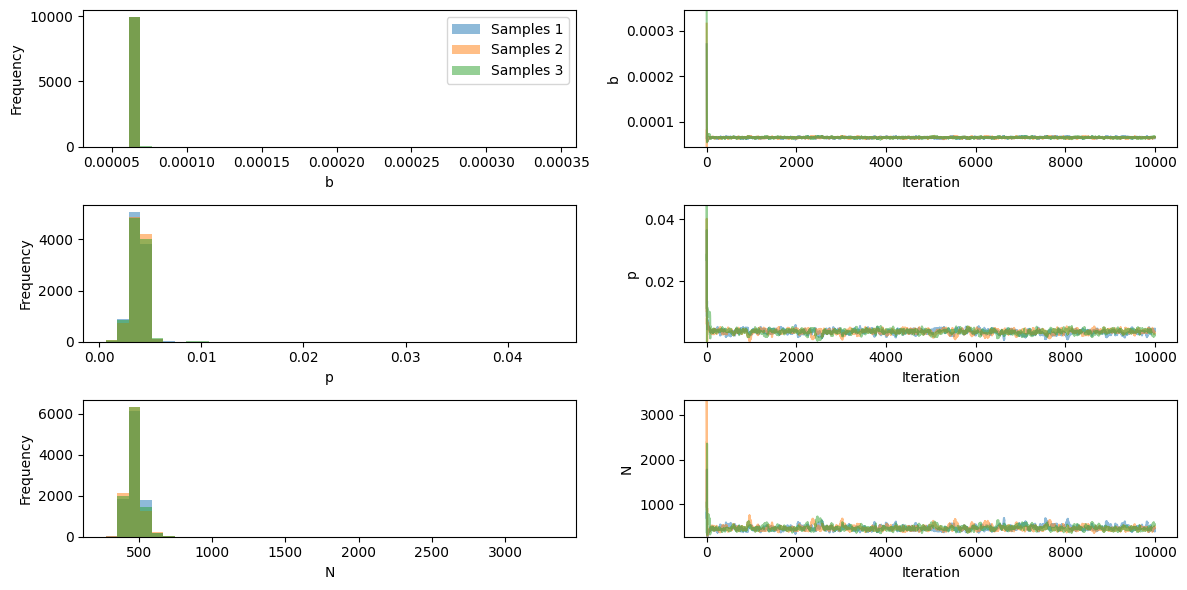

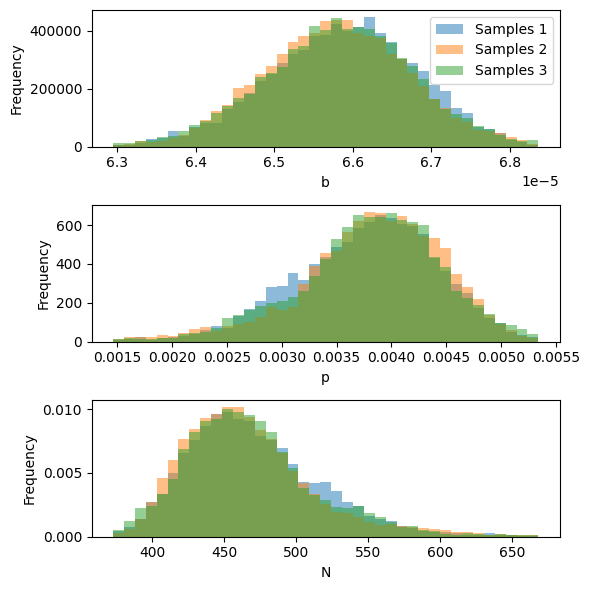

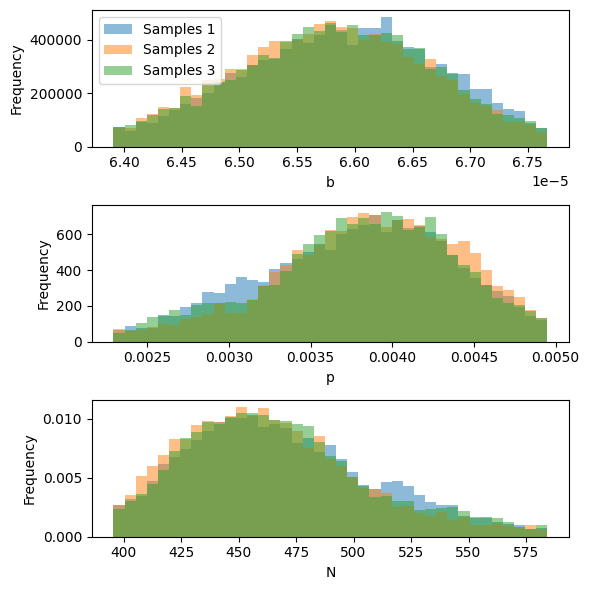

In [20]:
pints.plot.trace(chains[:,:,[0,1,2]], n_percentiles=99.5, parameter_names=["b","p","N"])
plt.savefig("pints_out_extremes_removed_PRO.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1,2]], parameter_names=["b","p","N"])
plt.savefig("pints_out_PRO.png", dpi=300)
plt.show()

ITERS=1000
pints.plot.histogram(chains[:,int(ITERS/2):, [0,1,2]], kde=False, n_percentiles=99.5, parameter_names=["b","p","N"])
plt.savefig("hist_only_exp_data_cst_prol_PRO.png")
plt.show()

pints.plot.histogram(chains[:,int(ITERS/2):, [0,1,2]], kde=False, n_percentiles=95, parameter_names=["b","p","N"])
plt.savefig("hist_only_exp_data_cst_prol_PRO_extremals_removed.png")
plt.show()